In [91]:
    # REPLACE WITH YOUR OWN KEY_VALUE
    key_value = "ENTER VALUE"

    import hopsworks
    import pandas as pd
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import GridSearchCV
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report
    import seaborn as sns
    from matplotlib import pyplot
    from hsml.schema import Schema
    from hsml.model_schema import ModelSchema
    import joblib
    import os

In [92]:
import os
 
for k, v in os.environ.items():
    if "HOPS" in k:
        print(f'{k}={v}')

In [58]:
# You have to set the environment variable 'HOPSWORKS_API_KEY' for login to succeed
project = hopsworks.login(api_key_value=key_value)
fs = project.get_feature_store()

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/193692
Connected. Call `.close()` to terminate connection gracefully.


In [59]:
#CONSTRUCTS 'FEATURE VIEW' from 'FEATURE GROUP' that is already saved from before on hopsworks, LABELS coming into play now, remember feature group only had features
# The feature view is the input set of features for your model. The features can come from different feature groups.    
# You can select features from different feature groups and join them together to create a feature view
wine_fg = fs.get_feature_group(name="wine", version=1)
query = wine_fg.select_all()
feature_view = fs.get_or_create_feature_view(name="wine",
                                  version=1,
                                  description="Read from Wine quality dataset",
                                  labels=["quality"],
                                  query=query)

In [80]:
# You can read training data, randomly split into train/test sets of features (X) and labels (y)        
X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2)           #80:20 split

# Train our model with the Scikit-learn K-nearest-neighbors algorithm using our features (X_train) and labels (y_train)
#model = KNeighborsClassifier(n_neighbors=2)     #CHANGE THIS MODEL FOR LATER IF YOU WISH
#model = DecisionTreeClassifier()
model = RandomForestClassifier() #(random_state=42)
model.fit(X_train, y_train.values.ravel())

Finished: Reading data from Hopsworks, using ArrowFlight (1.14s) 


RandomForestClassifier()

In [81]:
# Evaluate model performance using the features from the test set (X_test)
y_pred = model.predict(X_test)

# Compare predictions (y_pred) with the labels in the test set (y_test)
metrics = classification_report(y_test, y_pred, output_dict=True)
results = confusion_matrix(y_test, y_pred)
print(results)
print("-------------------------------------------------------------------------")

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy*100} %\n')
print("-------------------------------------------------------------------------")

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

[[  0   0   2   1   0   0   0]
 [  0   5  27  12   2   0   0]
 [  0   3 211 109   1   0   0]
 [  0   0 101 344  42   1   0]
 [  0   0   9  99  63   0   0]
 [  0   0   0  16  16   1   0]
 [  0   0   0   0   1   0   0]]
-------------------------------------------------------------------------
Accuracy: 58.536585365853654 %

-------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.62      0.11      0.19        46
           5       0.60      0.65      0.63       324
           6       0.59      0.70      0.64       488
           7       0.50      0.37      0.43       171
           8       0.50      0.03      0.06        33
           9       0.00      0.00      0.00         1

    accuracy                           0.59      1066
   macro avg       0.40      0.27      0.28      1066
weighted avg       0.58      0.59    

'\n# Set labels and title\npyplot.xlabel(\'Predicted Class\')\npyplot.ylabel(\'True Class\')\npyplot.title(\'Confusion Matrix\')\n\n# Save the figure as a PNG file\ncm.get_figure().savefig("confusion_matrix.png")\n\n# Show the plot\npyplot.show()\n'

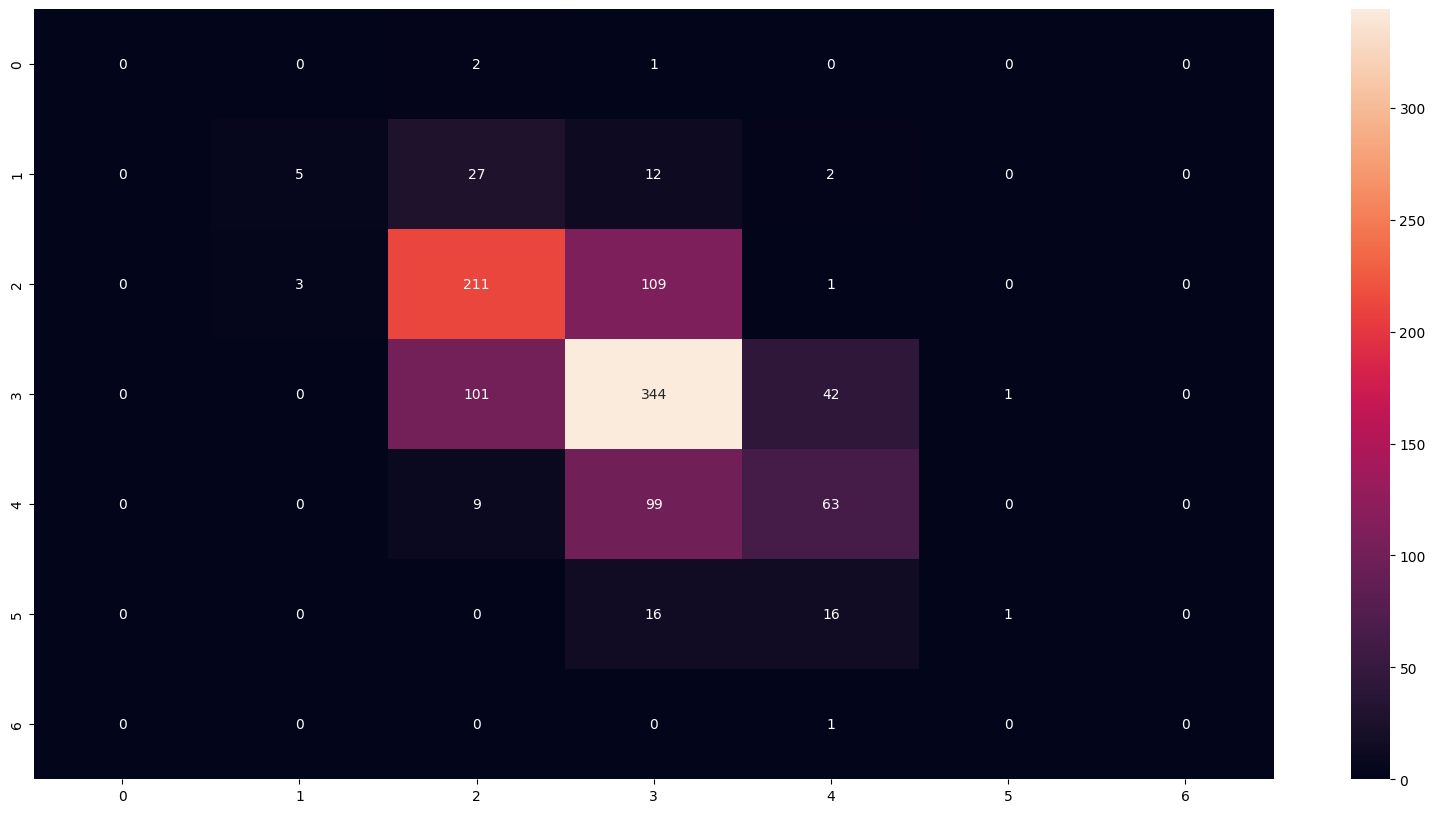

In [89]:
# Create the confusion matrix as a figure, we will later store it as a PNG image file

df_cm = pd.DataFrame(results)

# Create the heatmap
pyplot.figure(figsize=(20, 10))
cm = sns.heatmap(df_cm, annot=True, fmt="d")
fig = cm.get_figure()


In [90]:
# We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()

# The contents of the 'wine_model' directory will be saved to the model registry. Create the dir, first.
model_dir="wine_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
joblib.dump(model, model_dir + "/wine_model.pkl")       #binary serialization of model in python
fig.savefig(model_dir + "/wine_confusion_matrix.png")    

# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
wine_model = mr.python.create_model(
    name="wine_model", 
    metrics={"accuracy" : metrics['accuracy']},
    model_schema=model_schema,
    description="Wine Quality Predictor"
)

# Upload the model to the model registry, including all files in 'model_dir'
wine_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


Uploading: 100.000%|██████████| 24764609/24764609 elapsed<00:23 remaining<00:0097it/s]
Uploading: 100.000%|██████████| 30465/30465 elapsed<00:01 remaining<00:001,  2.97it/s]
Uploading: 100.000%|██████████| 1066/1066 elapsed<00:01 remaining<00:001:00, 15.17s/it]
Model export complete: 100%|██████████| 6/6 [00:33<00:00,  5.53s/it]                   

Model created, explore it at https://c.app.hopsworks.ai:443/p/193692/models/wine_model/1


Model(name: 'wine_model', version: 1)